In [2]:
import itertools
import yaml
from yaml.loader import SafeLoader
import mlflow
import mlflow.pyfunc
import joblib
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sdv.evaluation.single_table import run_diagnostic
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
from sdv.evaluation.single_table import get_column_plot
from sdv.evaluation.single_table import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

os.chdir('/home/onyxia/work/synthetic-data-sdc/')
os.environ["MLFLOW_TRACKING_URI"] = "https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/" 

In [3]:
variables = ['sex','age','agegr','placesize','edu','socprof','marital','ls','depress','trust','trustfam','trustneigh','sport','nofriend','smoke','alcabuse','alcsol','wkabint','englang','height','weight','bmi']

In [4]:
original = pd.read_csv('SDV/df_original.csv', names = variables)

In [5]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(original)

In [9]:
with open("SDV/config_ctgan.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

class CTGANWrapper(mlflow.pyfunc.PythonModel):
    def __init__(self):
        self.model = None

    def load_context(self, context):
        self.model = joblib.load(context.artifacts["model_path"])

    def predict(self, context, model_input):
        return self.model.sample(len(model_input))


In [18]:
run_name = 'ctgan_sd2011_dlr' + str(config['discriminator_lr']) + '_glr' + str(config['generator_lr']) + '_b' + str(config['batch_size']) + '_e' + str(config['epochs']) + '_gpu'


In [10]:

start_time = time.time()
ctgan = CTGANSynthesizer(metadata, 
                         verbose=False,
                         discriminator_lr=config['discriminator_lr'],
                         generator_lr=config['generator_lr'],
                         batch_size=config['batch_size'],
                         epochs = config['epochs'],
                         cuda = True)
ctgan.fit(original)
end_time = time.time()
ctgan.save(run_name + '.pkl')

/opt/conda/lib/python3.12/site-packages/sdv/single_table/base.py:97: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


Text(0.5, 1.0, "Loss d'un modèle TVAE sur SD2011")

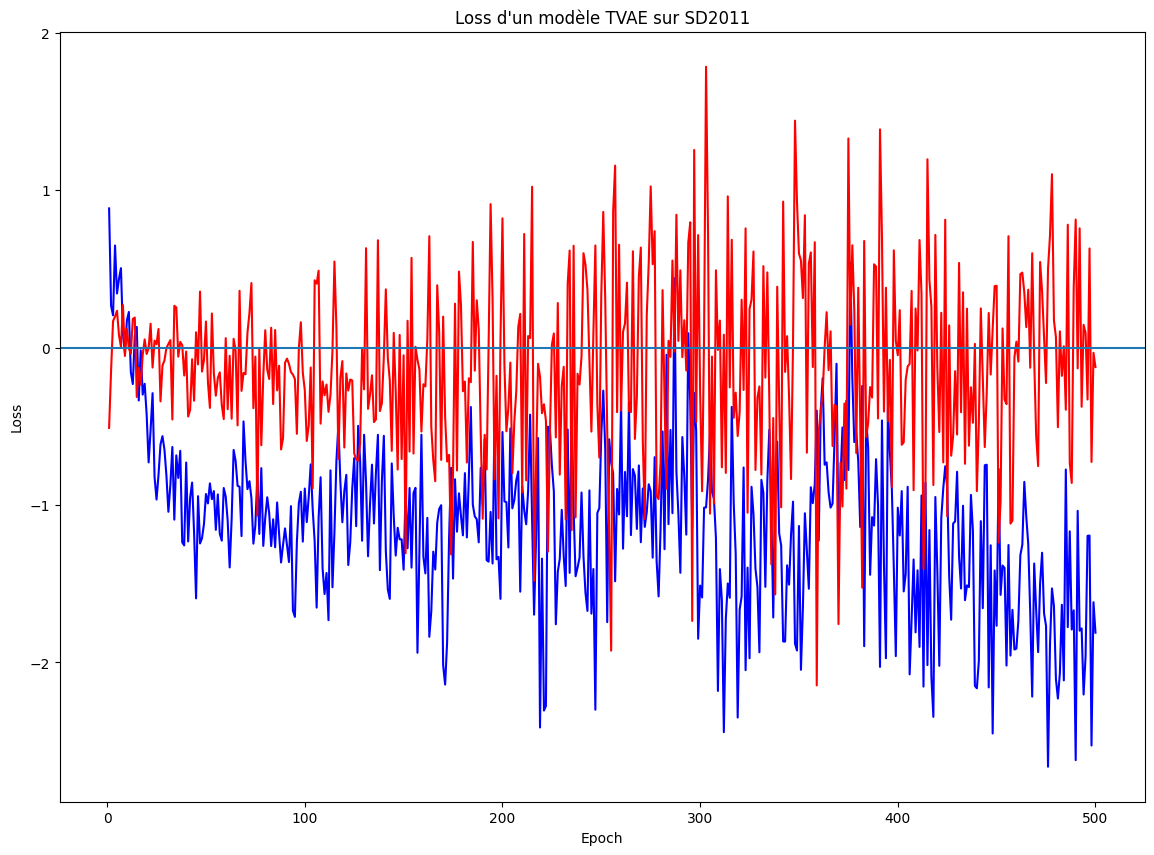

In [17]:
steps = range(1, config['epochs']+1)

plt.figure(figsize=(14, 10))

plt.plot(steps, ctgan.get_loss_values()['Generator Loss'], color='blue', label = "Generator")
plt.plot(steps, ctgan.get_loss_values()['Discriminator Loss'], color='red', label = "Discriminator")
plt.axhline(0)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss d'un modèle TVAE sur SD2011")

## Variabilité du modèle

In [23]:
with open("SDV/config_ctgan.yml") as f:
    config = yaml.load(f, Loader=SafeLoader)

In [ ]:
remote_server_uri = os.environ["MLFLOW_TRACKING_URI"]
experiment_name = 'Default'

all_gen_loss_by_epoch = {'epoch': [i for i in range(config['epochs'])]}
all_dis_loss_by_epoch = {'epoch': [i for i in range(config['epochs'])]}

In [36]:
for i in range(10,20):
    if (i+1)%10 == 0:
        print(i+1)
    run_name = 'ctgan_sd2011_dlr' + str(config['discriminator_lr']) + '_glr' + str(config['generator_lr']) + '_b' + str(config['batch_size']) + '_e' + str(config['epochs']) + '_iter' + str(i) + '_gpu'
    
    mlflow.set_tracking_uri(remote_server_uri)
    mlflow.set_experiment(experiment_name)
    
    with mlflow.start_run(run_name=run_name):
        for param_key, param_value in config.items():
            if param_key != 'mlflow':
                mlflow.log_param(param_key, param_value)
        mlflow.log_param('run_name', run_name)
    
        #Entraînement
        start_time = time.time()
        ctgan = CTGANSynthesizer(metadata,
                                verbose=False,
                                discriminator_lr=config['discriminator_lr'],
                                generator_lr=config['generator_lr'],
                                batch_size=config['batch_size'],
                                epochs = config['epochs'])
        ctgan.fit(original)
        end_time = time.time()
        
        elapsed_time = end_time - start_time
        mlflow.log_metric("elapsed_time", elapsed_time)
        print(f"Temps pris entraîner le modèle : {elapsed_time} secondes")
        
        params_ctgan = ctgan.get_parameters()
       
    
        # Log des paramètres du modèle
        for param_key, param_value in params_ctgan.items():
            with mlflow.start_run(nested=True):
                mlflow.log_param(param_key, param_value)
    
        gen_loss_by_epoch = ctgan.get_loss_values()['Generator Loss'].tolist()
        dis_loss_by_epoch = ctgan.get_loss_values()['Discriminator Loss'].tolist()
        
        nom_iter = 'iter'+str(i)
        all_gen_loss_by_epoch[nom_iter] = gen_loss_by_epoch
        all_dis_loss_by_epoch[nom_iter] = dis_loss_by_epoch
        
        for epoch, loss in enumerate(gen_loss_by_epoch):
            mlflow.log_metric("generator_loss", loss, step=epoch)
            
        for epoch, loss in enumerate(dis_loss_by_epoch):
            mlflow.log_metric("discriminator_loss", loss, step=epoch)
    
    
        model_path = run_name + ".pkl"
        joblib.dump(ctgan, model_path)
        mlflow.pyfunc.log_model(
            artifact_path="ctgan_model",
            python_model=CTGANWrapper(),
            artifacts={"model_path": model_path},
        )
        mlflow.log_artifact("SDV/config_ctgan.yml", artifact_path = "config_model")
        
    mlflow.end_run()

2024/08/30 15:48:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-croc-833 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/40ec01bf35384b399fa15c3ecc13ed9f.
2024/08/30 15:48:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.


Temps pris entraîner le modèle : 755.1977581977844 secondes


2024/08/30 15:48:59 INFO mlflow.tracking._tracking_service.client: 🏃 View run puzzled-mouse-969 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/9ace4068c0b94b6188e11ab44494a015.
2024/08/30 15:48:59 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 15:49:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run resilient-finch-631 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/867df52e1b664b14a7cacc19348e664b.
2024/08/30 15:49:00 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 15:49:00 INFO mlflow.tracking._tracking_service.client: 🏃 View run lyrical-donkey-1000 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/67446c3d0ae346df8a23dae907a20919.

Temps pris entraîner le modèle : 759.252685546875 secondes


2024/08/30 16:02:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run wistful-fawn-632 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/ea8ab214af054d5aa633fe776dc529ed.
2024/08/30 16:02:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:02:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run bald-loon-683 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/70035978d6534fbbb8c5bdcb57d336dd.
2024/08/30 16:02:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:02:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run wise-shoat-196 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/20ed50dd509d4653b6fecd25814f9b87.
2024/08/30 

Temps pris entraîner le modèle : 759.907731294632 secondes


2024/08/30 16:15:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run popular-pug-868 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/78f0293f5b2d4db69fb526f537c8b77d.
2024/08/30 16:15:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:15:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run chill-flea-414 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/ee2cf9e843484593a20f5dac9135414c.
2024/08/30 16:15:57 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:15:57 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-doe-97 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/42ea7b5c4b2c4f54a98872d8f633441c.
2024/08/30

Temps pris entraîner le modèle : 760.7917375564575 secondes


2024/08/30 16:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run incongruous-colt-956 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/72131a06fabe4a6dba27c8c486d77d10.
2024/08/30 16:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-loon-167 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/ac7673a54ff1449b9a82129871b1c117.
2024/08/30 16:29:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:29:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run clumsy-wren-623 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b72ae3f4083e4b399b3271f68d7d5a05.
2024/0

Temps pris entraîner le modèle : 759.3251330852509 secondes


2024/08/30 16:42:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run orderly-shark-130 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/9dec4aa63ce7459785f27df5ad3b1a95.
2024/08/30 16:42:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:42:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run spiffy-ant-993 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/769d121acfd24c2a96581e410abbf261.
2024/08/30 16:42:40 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:42:40 INFO mlflow.tracking._tracking_service.client: 🏃 View run luxuriant-mink-674 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/8f9af827fa1646d08a04bbc1ef1336d5.
2024/

Temps pris entraîner le modèle : 764.9816839694977 secondes


2024/08/30 16:56:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-trout-131 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/75b2e200386a48a5acaa9935d4499278.
2024/08/30 16:56:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:56:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run nervous-grub-177 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b5da42f026144324b9d7316df68ee5c5.
2024/08/30 16:56:08 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 16:56:08 INFO mlflow.tracking._tracking_service.client: 🏃 View run auspicious-gull-405 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/f2871c8adb094273be81a9a50c03c62f.
2024/

Temps pris entraîner le modèle : 757.2601940631866 secondes


2024/08/30 17:10:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run overjoyed-eel-9 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/2127298c16244dd5b28f945e97da667b.
2024/08/30 17:10:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:10:05 INFO mlflow.tracking._tracking_service.client: 🏃 View run delicate-bat-729 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/dba03e22705e42a0b0d29267e4c40d8b.
2024/08/30 17:10:05 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:10:06 INFO mlflow.tracking._tracking_service.client: 🏃 View run gaudy-rook-19 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/8656aab9885e44ff8f8db0e1a882554f.
2024/08/30

Temps pris entraîner le modèle : 763.7664966583252 secondes


2024/08/30 17:24:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run receptive-mare-982 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b0af002b8c16439a9f6ddd62f9bfbb26.
2024/08/30 17:24:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:24:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run clean-fox-578 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/7b6065934625485eae76a2701cd8caf9.
2024/08/30 17:24:12 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:24:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run peaceful-pig-584 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/d78505112acd4a9f85e7adf7b1e45357.
2024/08

Temps pris entraîner le modèle : 760.7288708686829 secondes


2024/08/30 17:38:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-chimp-473 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/15a9a23aa82842c2b0fdf59c3b5903a3.
2024/08/30 17:38:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:38:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run monumental-rat-860 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b911a568ca1d402f8ee0cc7cf4aec182.
2024/08/30 17:38:20 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:38:20 INFO mlflow.tracking._tracking_service.client: 🏃 View run merciful-lynx-438 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/a93756714c1046ca86547110b0f57168.
2

20


2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run hilarious-koi-414 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/a611ac52996f4b6bb4ab603d7023d4c4.
2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.


Temps pris entraîner le modèle : 763.6455557346344 secondes


2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run melodic-sow-775 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b6b4bfe0de3d47408111b7e13bb0c439.
2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run traveling-fly-381 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/a66c218766da452ea39370424a03cd66.
2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0.
2024/08/30 17:52:07 INFO mlflow.tracking._tracking_service.client: 🏃 View run calm-wasp-496 at: https://projet-donnees-synthetiques-mlflow.user.lab.sspcloud.fr/#/experiments/0/runs/b24919a80d544f6b963558017f9dd209.
2024/08/3

In [39]:
pd_all_gen_loss.shape

(500, 21)

In [38]:
pd_all_gen_loss = pd.DataFrame.from_dict(all_gen_loss_by_epoch)
pd_all_dis_loss = pd.DataFrame.from_dict(all_dis_loss_by_epoch)

all_gen_means = pd_all_gen_loss.loc[:, pd_all_gen_loss.columns != 'epoch'].mean(axis=1)
all_gen_sds = pd_all_gen_loss.loc[:, pd_all_gen_loss.columns != 'epoch'].std(axis=1)
all_gen_cvs = all_gen_sds/all_gen_means *100 
all_gen_min = pd_all_gen_loss.loc[:, pd_all_gen_loss.columns != 'epoch'].min(axis=1)
all_gen_max = pd_all_gen_loss.loc[:, pd_all_gen_loss.columns != 'epoch'].max(axis=1)

all_dis_means = pd_all_dis_loss.loc[:, pd_all_dis_loss.columns != 'epoch'].mean(axis=1)
all_dis_sds = pd_all_gen_loss.loc[:, pd_all_dis_loss.columns != 'epoch'].std(axis=1)
all_dis_cvs = all_dis_sds/all_dis_means *100 
all_dis_min = pd_all_dis_loss.loc[:, pd_all_dis_loss.columns != 'epoch'].min(axis=1)
all_dis_max = pd_all_dis_loss.loc[:, pd_all_dis_loss.columns != 'epoch'].max(axis=1)

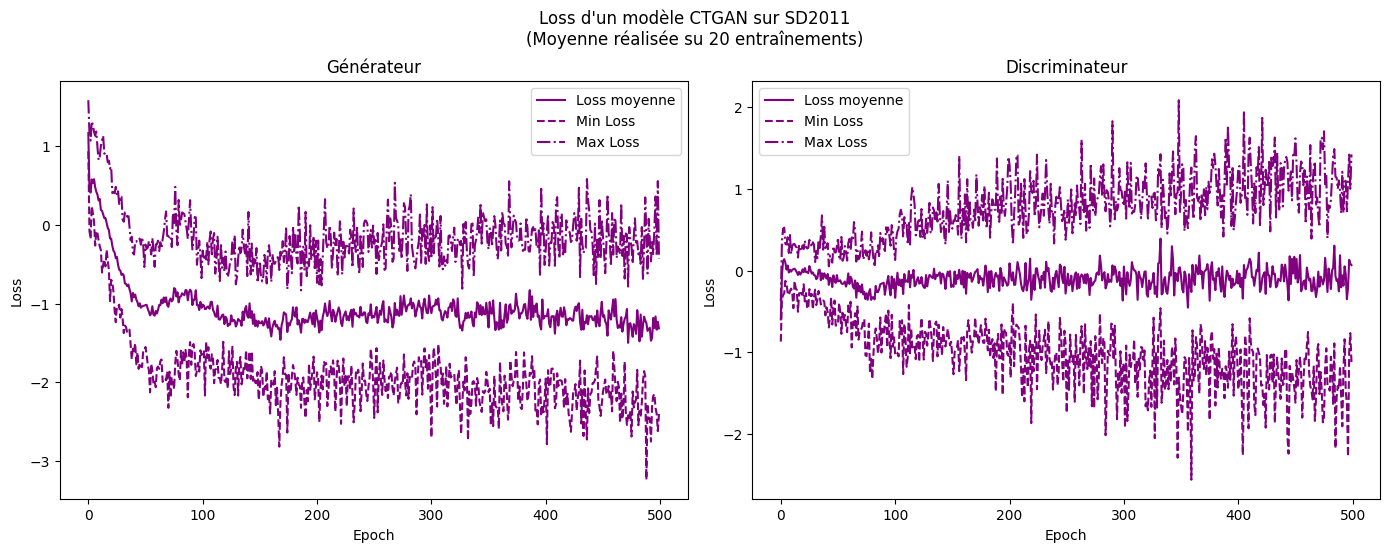

In [48]:
steps = range(500)

plt.figure(figsize=(14, 10))

plt.suptitle("Loss d'un modèle CTGAN sur SD2011\n(Moyenne réalisée su 20 entraînements)")

# Graphique 1 : Loss du Générateur
plt.subplot(2, 2, 1)

plt.plot(steps, all_gen_means, color='purple', label = "Loss moyenne")
#plt.plot(steps, loss_by_epoch_rapport, color='orange',label = "Modele retenu")
plt.plot(steps, all_gen_min, color='purple', linestyle='dashed', label = "Min Loss")
plt.plot(steps, all_gen_max, color='purple', linestyle='dashdot', label = "Max Loss")
#plt.axhline(loss_by_epoch_rapport[499], color = 'grey')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Générateur")
plt.legend()

# Graphique 1 : Loss du Discriminateur
plt.subplot(2, 2, 2)
plt.plot(steps, all_dis_means, color='purple', label = "Loss moyenne")
plt.plot(steps, all_dis_min, color='purple', linestyle='dashed', label = "Min Loss")
plt.plot(steps, all_dis_max, color='purple', linestyle='dashdot', label = "Max Loss")
#plt.axhline(loss_by_epoch_rapport[499], color = 'grey')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Discriminateur")

plt.tight_layout()
plt.savefig("MC_LOSS_CTGAN.pdf", bbox_inches='tight')

Text(0.5, 1.0, "Loss du discriminateur d'un modèle CTGAN sur SD2011\n(Moyenne réalisée su 20 entraînements)")

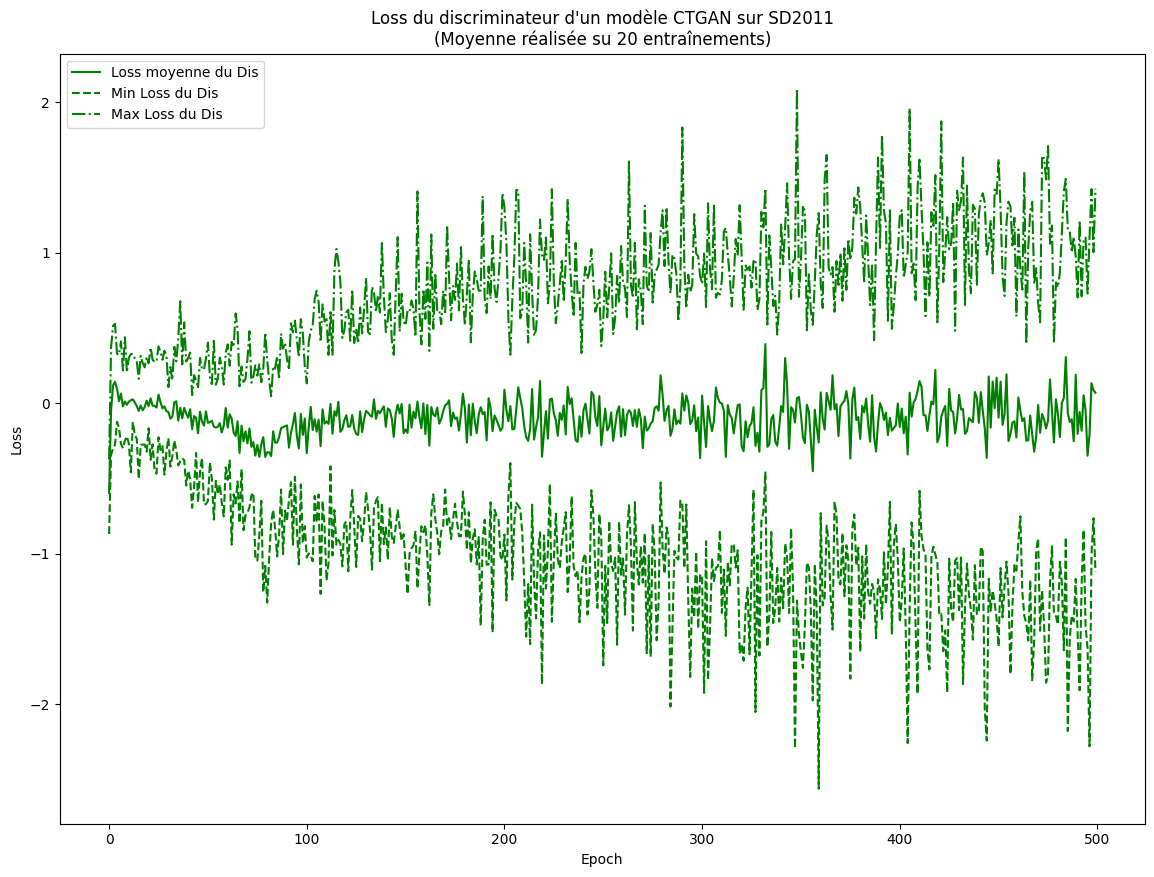

In [42]:
steps = range(500)

plt.figure(figsize=(14, 10))

